# Initialize

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from tqdm import tqdm

from models.Transformer import *
from prepare_data import get_time_series_dataloader
from utils.training import best_torch_device

In [49]:
cnn_path = "models/cnn"
cnn_rnn_path = "models/cnn_rnn"
resnet_path = "models/resnet"
transformer_path = "models/cnn_trans"

In [50]:
torch.manual_seed(0)
np.random.seed(0)

In [51]:
device = best_torch_device()
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [52]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


# Models

In [53]:
class CNN_ts(nn.Module):
    def __init__(self, n_time=1000):
        super(CNN_ts, self).__init__()

        self.filter_nums1 = 24  # 8
        self.filter_nums2 = 120  # 40
        self.filter_nums3 = 32  # 12
        num_groups = 8
        b = True
        dropout_prob = 0.25

        self.conv_over_time = nn.Sequential(
            nn.Conv2d(1, self.filter_nums1, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=b),
            nn.BatchNorm2d(self.filter_nums1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        # (n, 8, 22, 1001)

        self.conv_over_channels = nn.Sequential(
            nn.Conv2d(self.filter_nums1, self.filter_nums2, kernel_size=(22, 1), stride=(1, 1), groups=num_groups,
                      bias=b),
            nn.BatchNorm2d(self.filter_nums2, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),  # pool over time to shrink time
            nn.Dropout(p=dropout_prob)
        )
        # (n, 40, 1, 250)

        self.conv_by_channel_and_point = nn.Sequential(
            nn.Conv2d(self.filter_nums2, self.filter_nums2, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8),
                      groups=num_groups, bias=b),
            # (n, 40, 1, 251)
            nn.Conv2d(self.filter_nums2, self.filter_nums3, kernel_size=(1, 1), stride=(1, 1), bias=False),
            # (n, 12, 1, 251)
            nn.BatchNorm2d(self.filter_nums3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
            # nn.Conv2d(self.filter_nums3, 4, kernel_size=(1, 31), stride=(1, 1)) # conv to 4 output classes
            # (n, 4, 1, 1)
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(4)  # the last convolution is replaced by linear
        )

    def forward(self, x):
        # x = x.to('mps')
        # X (batch, ch, t)
        x = x.unsqueeze(3)
        # (batch, ch, t, 1)
        x = x.permute(0, 3, 1, 2)
        # (batch, 1, ch, t)
        x = self.conv_over_time(x)
        x = self.conv_over_channels(x)
        x = self.conv_by_channel_and_point(x)
        x = self.linear(x)

        return x

In [54]:
class RNNWithCNN(nn.Module):
    """
    Combination of RNN and CNN.

    Architecture
    - Input: (N, D, T), D (num of features), T (num of time steps)
    - 1D Convolutions along temporal dimension
        - Conv - ELU - BN - MaxPool - Dropout
    - LSTM's
    - Fully connected layers
    """

    def __init__(
            self,
            num_class: int = 4,
            features_dim: int = 22,
            time_dim: int = 1000,
    ):
        super(RNNWithCNN, self).__init__()

        # CNN
        self.cnn = nn.Sequential(
            nn.LazyConv1d(out_channels=32, kernel_size=8, padding=4),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=64, kernel_size=10, padding=5),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=128, kernel_size=12, padding=6),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),

            nn.LazyConv1d(out_channels=256, kernel_size=14, padding=7),
            nn.ELU(),
            nn.LazyBatchNorm1d(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.5),
        )

        # Test CNN output
        t = torch.rand(2, features_dim, time_dim)
        t = self.cnn(t)
        rnn_input_size = t.shape[2]

        # self.flatten = nn.Flatten(start_dim=2)

        # RNN
        self.rnn1 = nn.LSTM(
            input_size=rnn_input_size,
            hidden_size=150,
            num_layers=1,
            batch_first=True,
        )
        self.rnn2 = nn.LSTM(
            input_size=150,
            hidden_size=75,
            num_layers=1,
            dropout=0.5,
            batch_first=True,
        )

        # Fully connected layers - 2
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(150),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(num_class),
        )

    def forward(self, x):
        # x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        # x = x.permute(0, 1, 3, 2)

        x = self.cnn(x)
        # x = self.flatten(x)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = self.fc(x)

        # Softmax
        softmax = nn.Softmax(dim=1)
        x = softmax(x)

        return x

In [55]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        # self.dropout = nn.Dropout(0.2)
        self.downsample = downsample
        self.elu = nn.ELU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.elu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, 50, kernel_size=70, stride=1, padding=35)
        self.bn = nn.BatchNorm1d(50)
        self.elu = nn.ELU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.elu = nn.ELU()
        self.layer1 = ResidualBlock(50, 22, stride=2, downsample=nn.Sequential(
            nn.Conv1d(50, 22, kernel_size=1, stride=2),
            nn.BatchNorm1d(22)))
        self.layer2 = ResidualBlock(22, 24, stride=2, downsample=nn.Sequential(
            nn.Conv1d(22, 24, kernel_size=1, stride=2),
            nn.BatchNorm1d(24)))
        # self.layer3 = ResidualBlock(90, 90)
        # self.layer4 = ResidualBlock(256, 256)
        self.avg_pool = nn.AdaptiveAvgPool1d(12)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(24 * 12, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.bn(x)
        x = self.elu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        # x = self.layer5(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Reference for building ResNet:
# https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
# https://debuggercafe.com/building-resnets-from-scratch-using-pytorch/

# Evaluate

In [56]:
cnn_test_acc = {}
cnn_val_acc = {}

for ts in tqdm(time_slots):
    # Load model
    model = torch.load(f"{cnn_path}/time_{ts}.pt")
    model.to(device)
    model.eval()

    # Load data
    _, valid_data, test_data = get_time_series_dataloader(ts)

    # Evaluate on validation
    cnn_val_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            cnn_val_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    cnn_val_acc[ts] /= len(valid_data.dataset)

    # Evaluate on test
    cnn_test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            cnn_test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    cnn_test_acc[ts] /= len(test_data.dataset)

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


In [57]:
cnn_rnn_test_acc = {}
cnn_rnn_val_acc = {}

for ts in tqdm(time_slots):
    # Load model
    model = torch.load(f"{cnn_rnn_path}/time_{ts}.pt")
    model.to(device)
    model.eval()

    # Load data
    _, valid_data, test_data = get_time_series_dataloader(ts)

    # Evaluate on validation
    cnn_rnn_val_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            cnn_rnn_val_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    cnn_rnn_val_acc[ts] /= len(valid_data.dataset)

    # Evaluate on test
    cnn_rnn_test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            cnn_rnn_test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    cnn_rnn_test_acc[ts] /= len(test_data.dataset)

100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


In [58]:
resnet_test_acc = {}
resnet_val_acc = {}

device = "cpu"
for ts in tqdm(time_slots):
    # Load model
    model = torch.load(f"{resnet_path}/time_{ts}.pt")
    model.to(device)
    model.eval()

    # Load data
    _, valid_data, test_data = get_time_series_dataloader(ts)

    # Evaluate on validation
    resnet_val_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            resnet_val_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    resnet_val_acc[ts] /= len(valid_data.dataset)

    # Evaluate on test
    resnet_test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            resnet_test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    resnet_test_acc[ts] /= len(test_data.dataset)

device = best_torch_device()

100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


In [59]:
transformer_test_acc = {}
transformer_val_acc = {}

for ts in tqdm(time_slots):
    # Load model
    model = torch.load(f"{transformer_path}/time_{ts}.pt")
    model.device = device
    model.to(device)
    model.eval()

    # Load data
    _, valid_data, test_data = get_time_series_dataloader(ts)

    # Evaluate on validation
    transformer_val_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            transformer_val_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    transformer_val_acc[ts] /= len(valid_data.dataset)

    # Evaluate on test
    transformer_test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            transformer_test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    transformer_test_acc[ts] /= len(test_data.dataset)

100%|██████████| 8/8 [00:01<00:00,  4.32it/s]


# Plot

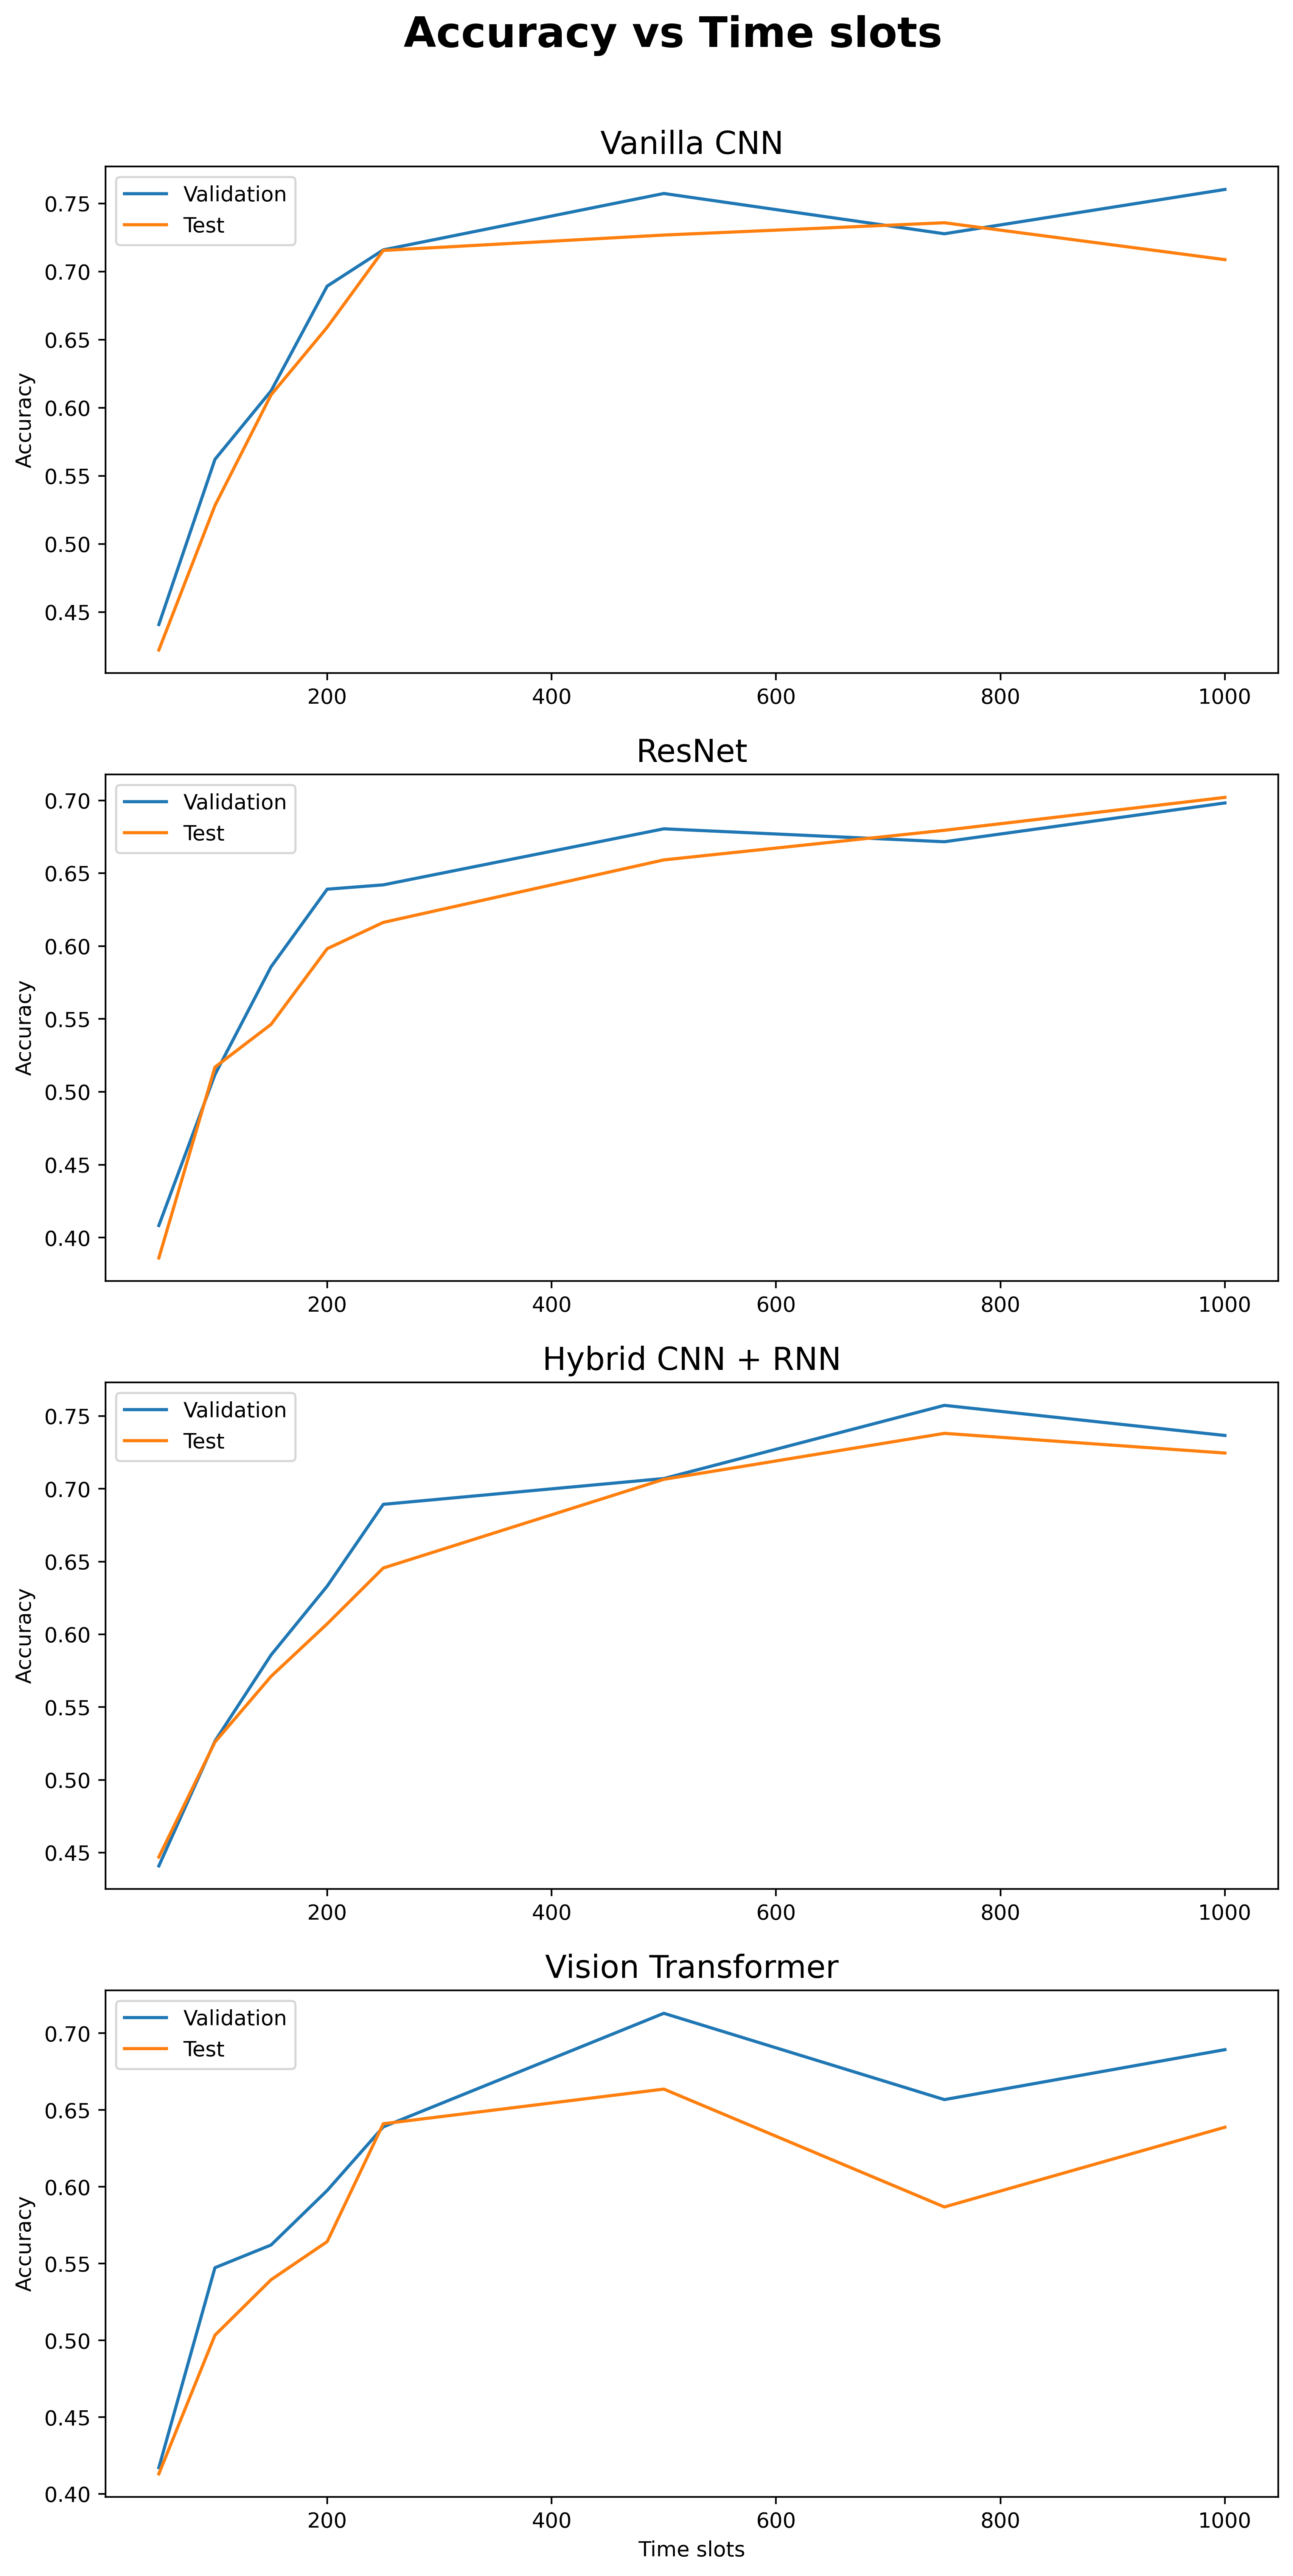

In [60]:
fig, axs = plt.subplots(4, 1, dpi=400, figsize=(10, 20))

axs[0].plot(time_slots, list(cnn_val_acc.values()), label="Validation")
axs[0].plot(time_slots, list(cnn_test_acc.values()), label="Test")
axs[0].set_title("Vanilla CNN", fontsize=15)
# axs[0].set_xlabel("Time slots")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(time_slots, list(resnet_val_acc.values()), label="Validation")
axs[1].plot(time_slots, list(resnet_test_acc.values()), label="Test")
axs[1].set_title("ResNet", fontsize=15)
# axs[2].set_xlabel("Time slots")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

axs[2].plot(time_slots, list(cnn_rnn_val_acc.values()), label="Validation")
axs[2].plot(time_slots, list(cnn_rnn_test_acc.values()), label="Test")
axs[2].set_title("Hybrid CNN + RNN", fontsize=15)
# axs[1].set_xlabel("Time slots")
axs[2].set_ylabel("Accuracy")
axs[2].legend()

axs[3].plot(time_slots, list(transformer_val_acc.values()), label="Validation")
axs[3].plot(time_slots, list(transformer_test_acc.values()), label="Test")
axs[3].set_title("Vision Transformer", fontsize=15)
axs[3].set_xlabel("Time slots")
axs[3].set_ylabel("Accuracy")
axs[3].legend()

# title
plt.suptitle("Accuracy vs Time slots", fontsize=20, fontweight='bold', y=0.93)

plt.show()